In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import detect_cas

/sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
import json

COCO_ROOT = '/scratch/gsk6me/WORLDMODELS'
LVIS_VAL_ANNOTATIONS_PATH = '/scratch/gsk6me/WORLDMODELS/lvis_v1_val.json'
LVIS_TRAIN_ANNOTATIONS_PATH = '/scratch/gsk6me/WORLDMODELS/lvis_v1_train.json'

with open(LVIS_VAL_ANNOTATIONS_PATH) as f:
    validation_anns = json.load(f)
    
with open(LVIS_TRAIN_ANNOTATIONS_PATH) as f:
    train_anns = json.load(f)

In [4]:
# Take the first 100 images with at least 1 category
image_ids = []
images = {}
for image in train_anns['images']:
    if len(image['not_exhaustive_category_ids']) > 0:
        image_ids.append(image['id'])
        images[image['id']] = image
    
    if len(image_ids) == 100:
        break


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
categories = {
    category['id']: category
    for category in train_anns['categories']
}

In [6]:
categories[16]

{'name': 'aquarium',
 'instance_count': 36,
 'def': 'a tank/pool/bowl filled with water for keeping live fish and underwater animals',
 'synonyms': ['aquarium', 'fish_tank'],
 'image_count': 33,
 'id': 16,
 'frequency': 'c',
 'synset': 'aquarium.n.01'}

In [7]:
# Now we can try inference.
image_id = image_ids[0]
image = images[image_id]
image

{'flickr_url': 'http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg',
 'id': 184613,
 'neg_category_ids': [1069,
  74,
  1004,
  419,
  484,
  1106,
  98,
  423,
  771,
  1113,
  210,
  729,
  44,
  46],
 'not_exhaustive_category_ids': [947, 80],
 'width': 500,
 'license': 3,
 'coco_url': 'http://images.cocodataset.org/train2017/000000184613.jpg',
 'date_captured': '2013-11-14 12:36:29',
 'height': 336}

In [9]:
import gc
_before = torch.cuda.memory_reserved(0)
gc.collect()
torch.cuda.empty_cache()
_after = torch.cuda.memory_reserved(0)
print(f"Saved {_before - _after} bytes of memory from cache clearance")

Saved 0 bytes of memory from cache clearance


['cabinet', 'stove']
['earplug', 'flash', 'bear', 'coconut', 'dresser', 'button', 'cab (taxi)', 'beer bottle', 'baseball cap', 'dispenser', 'matchbox', 'hot sauce', 'chili (vegetable)', 'blueberry', 'calculator']
Generated coarse detections.
Generated captions.
Generated logits.
OwlV2 detection time: 0.76
Caption generation time: 9.09
Logit generation time: 6.18


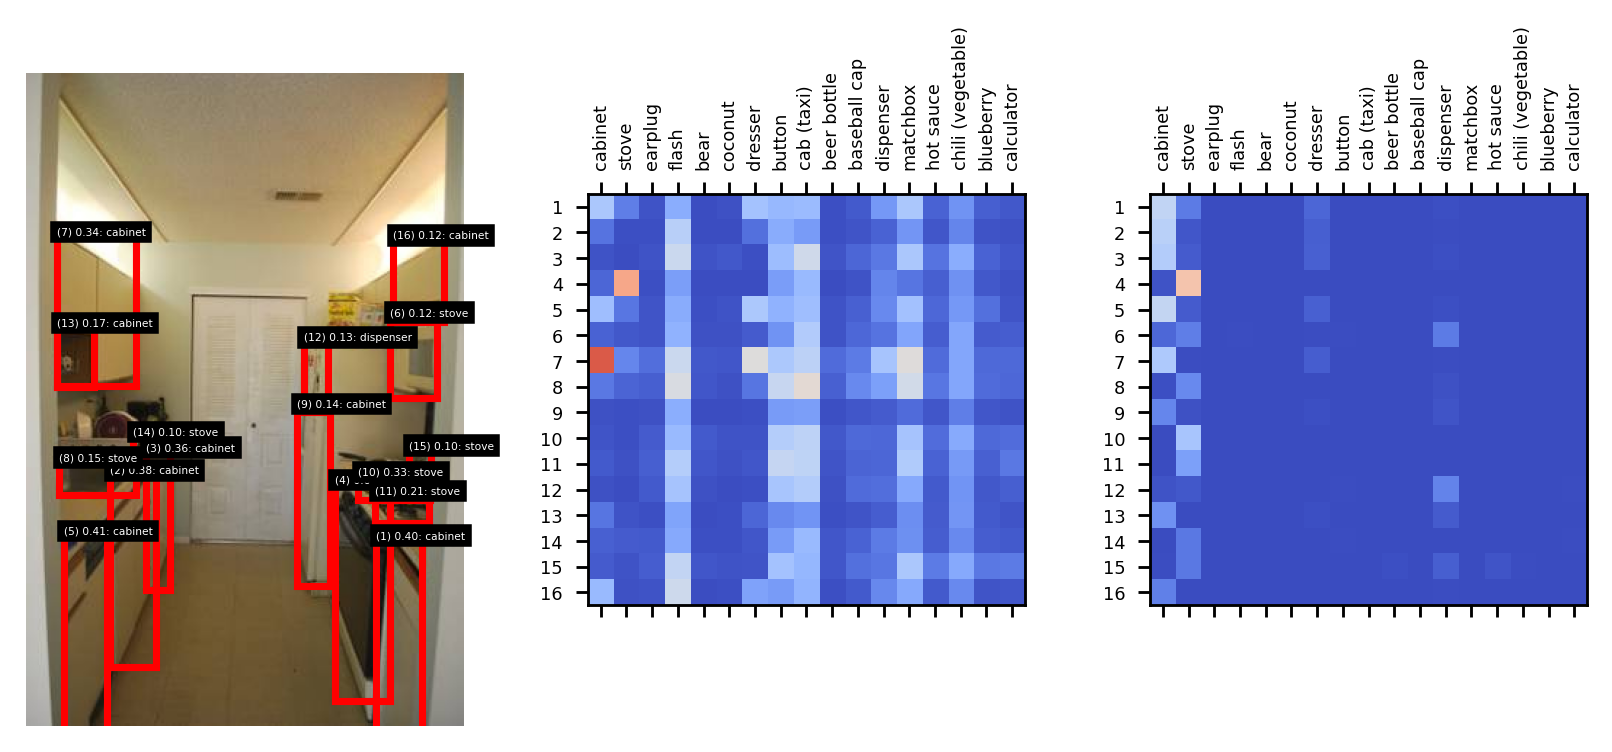

In [20]:
import numpy as np
import PIL.Image
import os
import matplotlib.pyplot as plt

# Now we can try inference.
image_id = image_ids[5]
image_metadata = images[image_id]
offset = len('http://images.cocodataset.org/')
image = PIL.Image.open(os.path.join(COCO_ROOT, image_metadata['coco_url'][offset:]))

positive_category_names = [
    categories[cid]['name'].replace("_", " ")
    for cid in image_metadata['not_exhaustive_category_ids']
]
negative_category_names = [
    categories[cid]['name'].replace("_", " ")
    for cid in image_metadata['neg_category_ids']
]

print(positive_category_names)
print(negative_category_names)

import detect_cas
import matplotlib.patches as patches

possible_labels = positive_category_names + negative_category_names

# Visualize the results.
(captions, crops, binary_logits, coarse_detection_outputs) = detect_cas.detect(image, possible_labels, verbose=True)

(boxes, scores, logits, outputs) = coarse_detection_outputs

fig = plt.figure(dpi=256)

##### BOUNDING BOXES ON IMAGE #####
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image)
for i, (x1, y1, x2, y2) in enumerate(boxes.cpu().numpy()):
    ax.add_patch(patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor='r', linewidth=2
    ))
    
    text_x = x1
    text_y = max(y1 - 2, 10)

    if (x1 / image.width) > 0.9:
        text_x = x2
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'left'
        
    label = possible_labels[scores[i].argmax()]
    ax.text(
        text_x, text_y, f"({i + 1}) {scores[i].max():.2f}: {label}", c='white',
        backgroundcolor=(0, 0, 0, 1.0),
        horizontalalignment=horizontalalignment,
        size=3,
    )

plt.axis('off')

##### SCORES FROM VLM #####
ax = fig.add_subplot(1, 3, 2)
# Create a little confusion matrix.

# apply sigmoid to get scores
data = 1/(1 + np.exp(-binary_logits.detach().cpu().numpy()))

# Create a heatmap with the data
cax = ax.matshow(data, cmap='coolwarm', vmin=0, vmax=1)

# Loop over data dimensions and create text annotations.
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         text = ax.text(j, i, f"{data[i, j]:.2f}",
#                        ha="center", va="center", color="black", size=6)

# Set labels for x and y axis
ax.set_xticks(np.arange(data.shape[1]))
ax.set_yticks(np.arange(data.shape[0]))

##### SCORES FROM OWLV2 #####

# Optionally set axis labels
ax.set_xticklabels(possible_labels, fontsize=5)
ax.set_yticklabels([str(i + 1) for i in range(len(captions))], fontsize=5)
ax.tick_params(axis='x', rotation=90)

ax = fig.add_subplot(1, 3, 3)
# Create a little confusion matrix.

# apply sigmoid to get scores
data = scores.detach().cpu().numpy()

# Create a heatmap with the data
cax = ax.matshow(data, cmap='coolwarm', vmin=0, vmax=1)

# Loop over data dimensions and create text annotations.
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         text = ax.text(j, i, f"{data[i, j]:.2f}",
#                        ha="center", va="center", color="black", size=6)

# Set labels for x and y axis
ax.set_xticks(np.arange(data.shape[1]))
ax.set_yticks(np.arange(data.shape[0]))

# Optionally set axis labels
ax.set_xticklabels(possible_labels, fontsize=5)
ax.set_yticklabels([str(i + 1) for i in range(len(captions))], fontsize=5)
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()

plt.show()


In [15]:
captions[14]

'The image is a blurred, abstract representation of a dark, moody background with a subtle gradient of colors. The image does not contain any discernible objects or text, and the overall composition is devoid of any specific details or focal points.'

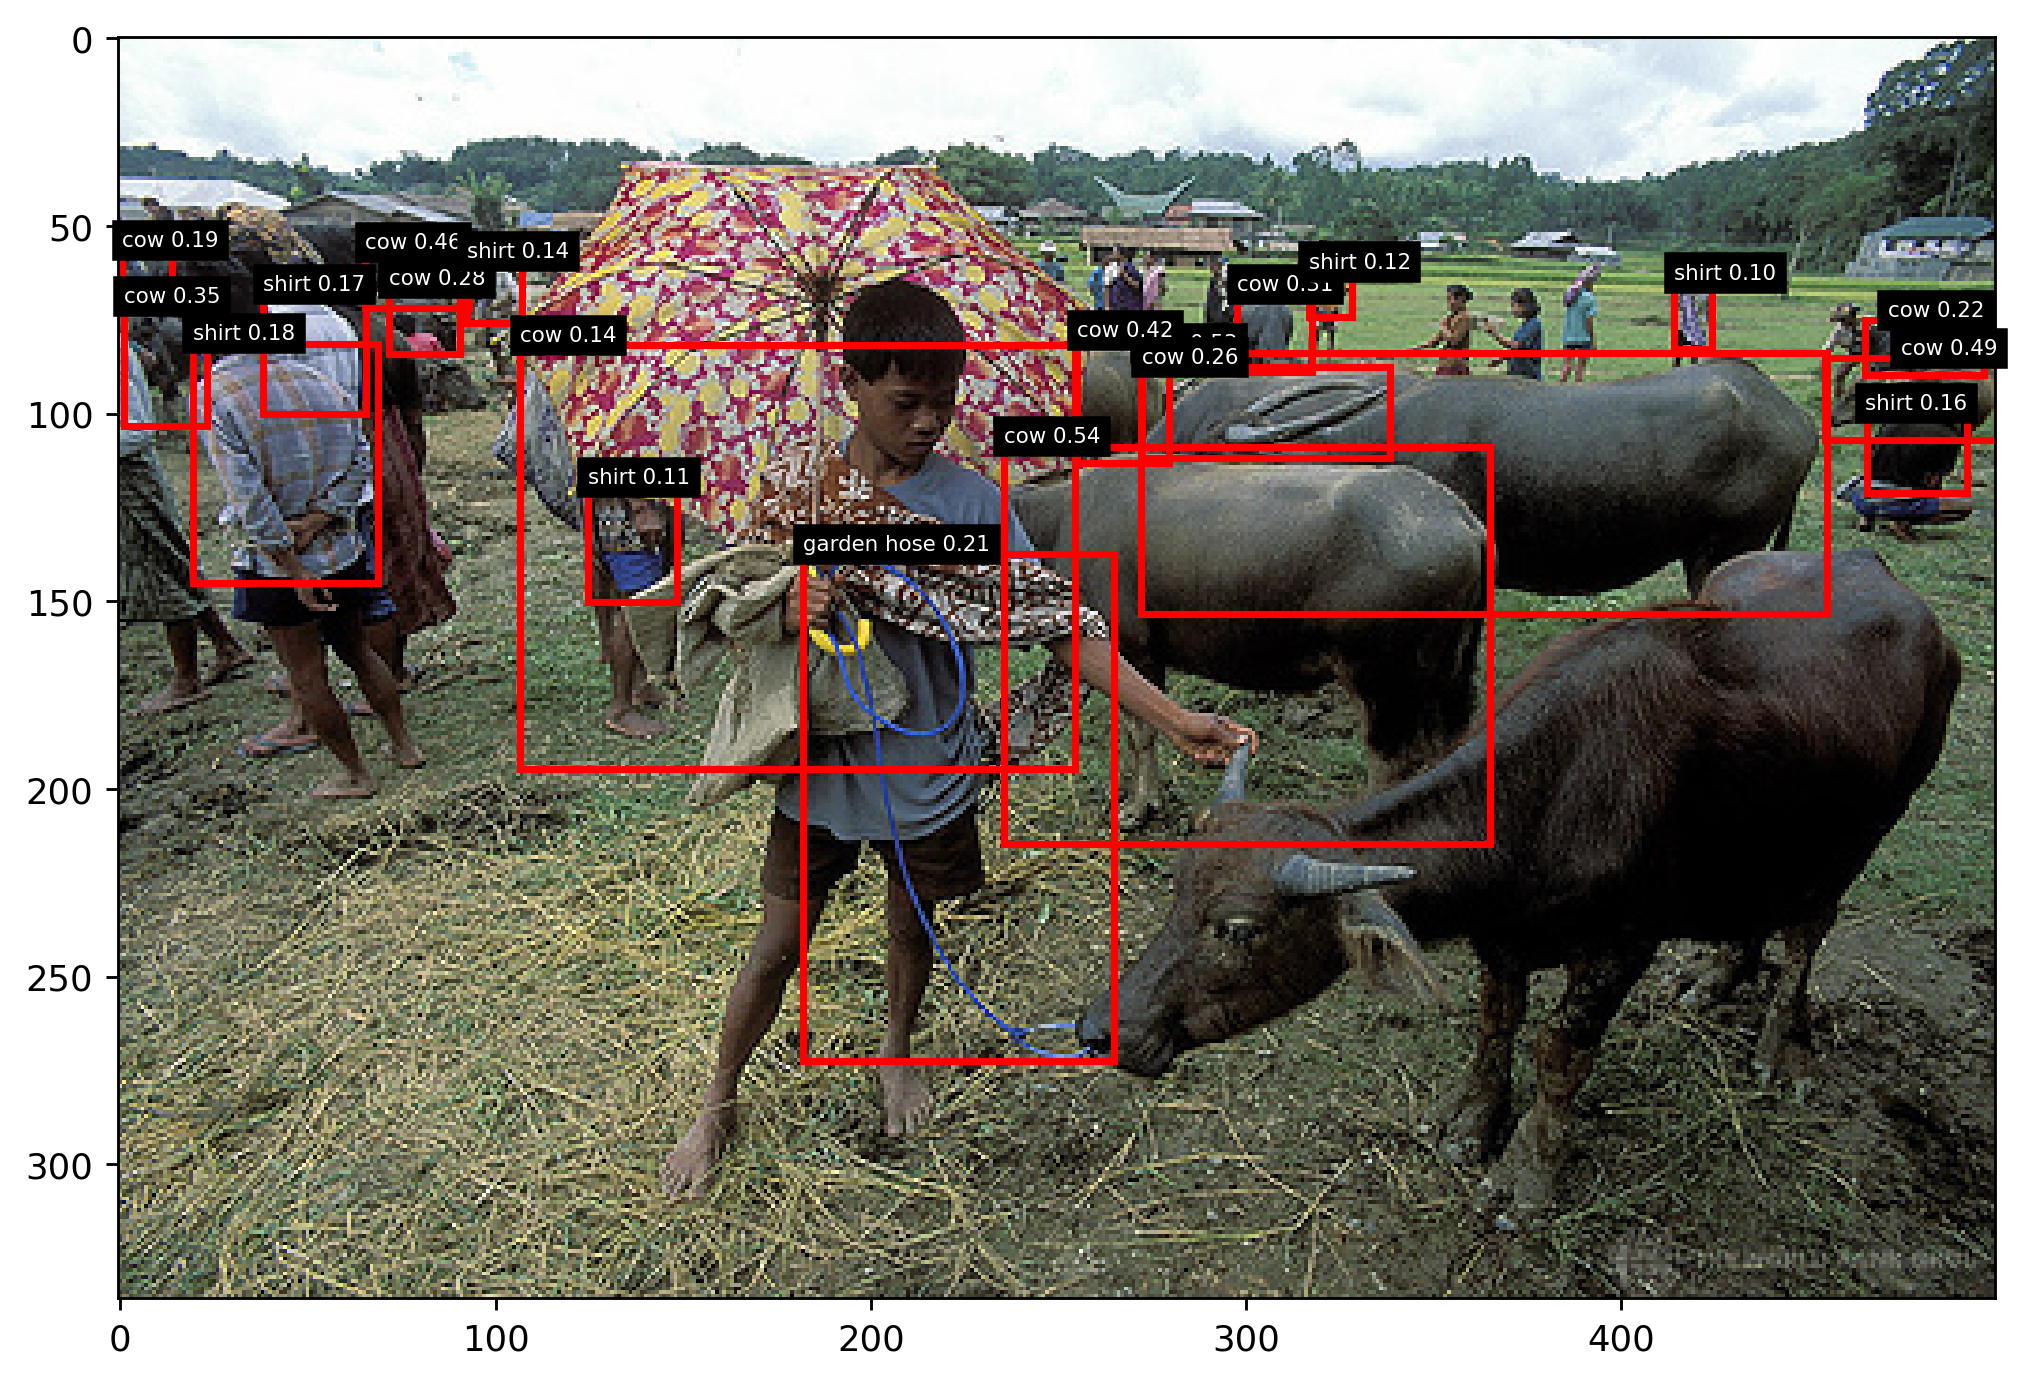

In [25]:
fig = plt.figure(dpi=256, figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image)

for i, (x1, y1, x2, y2) in enumerate(boxes.cpu().numpy()):
    ax.add_patch(patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor='r', linewidth=2
    ))
    
    score = scores[i].max()
    label = possible_labels[scores[i].argmax()]
    
    text_x = x1
    text_y = max(y1 - 1, 10)

    if (x1 / image.width) > 0.9:
        text_x = x2
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'left'
        
    ax.text(
        text_x, text_y, f"{label} {score:.2f}", c='white',
        backgroundcolor=(0, 0, 0, 1.0),
        horizontalalignment=horizontalalignment,
        size=6,
    )
    
plt.tight_layout()
plt.show()